In [2]:
!pip install torch-geometric

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch_geometric.nn import HypergraphConv, AttentionalAggregation
import matplotlib.pyplot as plt


c:\Users\Name\anaconda3\envs\MLreal\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    )
    ])
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

print(train_dataset.data.shape)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

100%|██████████| 170M/170M [00:10<00:00, 15.8MB/s] 


(50000, 32, 32, 3)


# image->hypergraph

In [5]:
def image_to_dynamic_hypergraph(images, k_spatial=4, k_feature=4):
    batch_node_feats = []
    batch_edge_index = []
    batch_map = []
    node_offset = 0

    for b, img in enumerate(images):
        # img: [C,H,W] -> patches
        C, H, W = img.shape
        patch_size = 8  # 8x8 patches for CIFAR-10
        patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        patches = patches.contiguous().view(C, -1, patch_size, patch_size)
        patches = patches.view(patches.size(1), -1)  # flatten each patch to vector

        num_nodes = patches.size(0)
        node_feats = patches

        # Spatial eges (static)
        spatial_edges = []
        coords = np.array([[i // (W // patch_size), i % (W // patch_size)] for i in range(num_nodes)])
        for i in range(num_nodes):
            dists = np.sum((coords - coords[i])**2, axis=1)
            nn_idx = np.argsort(dists)[1:k_spatial+1]
            for j in nn_idx:
                spatial_edges.append([i, j])

        # Feature hyperedges (dynamic, computed on GPU)
        feats = node_feats
        feats = feats.to(images.device)
        dists_feat = torch.cdist(feats.float(), feats.float(), p=2)
        feature_edges = []
        for i in range(num_nodes):
            nn_idx = torch.topk(dists_feat[i], k=k_feature+1, largest=False).indices[1:]
            for j in nn_idx:
                feature_edges.append([i, j])

        all_edges = torch.tensor(spatial_edges + feature_edges, dtype=torch.long, device=images.device).T
        batch_node_feats.append(node_feats)
        batch_edge_index.append(all_edges + node_offset)
        batch_map.append(torch.full((num_nodes,), b, dtype=torch.long, device=images.device))

        node_offset += num_nodes

    x = torch.cat(batch_node_feats, dim=0).float()
    edge_index = torch.cat(batch_edge_index, dim=1)
    batch_map = torch.cat(batch_map)
    return x, edge_index, batch_map

In [6]:
class HyperVigClassifier(nn.Module):
  def __init__(self, in_channels, hidden, num_classes):
    super().__init__()
    self.conv1 = HypergraphConv(in_channels, hidden)
    self.conv2 = HypergraphConv(hidden, hidden)
    self.conv3 = HypergraphConv(hidden, hidden)
    self.pool = AttentionalAggregation(gate_nn=nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, 1)))
    self.classifier = nn.Linear(hidden, num_classes)

  def forward(self, x, edge_index, batch_map):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = self.conv3(x, edge_index)
    x = F.relu(x)
    out = self.pool(x, batch_map) #attention pooling
    out = self.classifier(out)
    return out

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = HyperVigClassifier(in_channels=3*8*8, hidden=256, num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Lists to store training history
train_accuracies = []
train_losses = []

num_epochs = 30
for epoch in range(num_epochs):
  model.train()
  total_loss = 0
  correct = 0
  total = 0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    node_feats, edge_index, batch_map = image_to_dynamic_hypergraph(images)
    node_feats, edge_index, batch_map = node_feats.to(device), edge_index.to(device), batch_map.to(device)
    optimizer.zero_grad()
    outputs = model(node_feats, edge_index, batch_map)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item() * images.size(0)
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  epoch_loss = total_loss / total
  epoch_accuracy = correct / total
  train_losses.append(epoch_loss)
  train_accuracies.append(epoch_accuracy)
  
  print(f"Epoch {epoch+1}, Loss: {epoch_loss:.5f}, Accuracy: {epoch_accuracy:.5f}")

Epoch 1, Loss: 2.08841, Accuracy: 0.23588
Epoch 2, Loss: 1.98319, Accuracy: 0.27794
Epoch 3, Loss: 1.93544, Accuracy: 0.29424
Epoch 4, Loss: 1.90240, Accuracy: 0.30830
Epoch 5, Loss: 1.88102, Accuracy: 0.31578
Epoch 6, Loss: 1.85396, Accuracy: 0.32662
Epoch 7, Loss: 1.83340, Accuracy: 0.33246
Epoch 8, Loss: 1.81480, Accuracy: 0.34076
Epoch 9, Loss: 1.79395, Accuracy: 0.35226
Epoch 10, Loss: 1.77268, Accuracy: 0.35684
Epoch 11, Loss: 1.75711, Accuracy: 0.36418
Epoch 12, Loss: 1.73812, Accuracy: 0.36976
Epoch 13, Loss: 1.71796, Accuracy: 0.37926
Epoch 14, Loss: 1.69849, Accuracy: 0.38436
Epoch 15, Loss: 1.67800, Accuracy: 0.39250
Epoch 16, Loss: 1.66068, Accuracy: 0.39882
Epoch 17, Loss: 1.63685, Accuracy: 0.40820
Epoch 18, Loss: 1.61838, Accuracy: 0.41664
Epoch 19, Loss: 1.59669, Accuracy: 0.42284
Epoch 20, Loss: 1.57577, Accuracy: 0.43078
Epoch 21, Loss: 1.55309, Accuracy: 0.43838
Epoch 22, Loss: 1.53505, Accuracy: 0.44544
Epoch 23, Loss: 1.50864, Accuracy: 0.45548
Epoch 24, Loss: 1.49

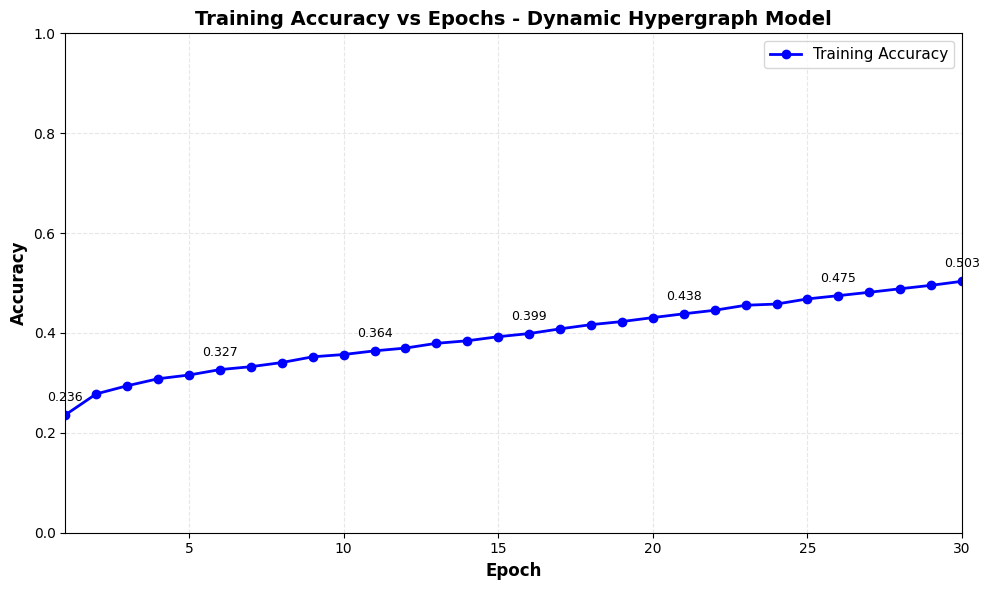


Final Training Accuracy: 0.5035 (50.35%)
Best Training Accuracy: 0.5035 (50.35%) at Epoch 30


In [8]:
# Plot Accuracy vs Epochs
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, 'b-o', linewidth=2, markersize=6, label='Training Accuracy')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Training Accuracy vs Epochs - Dynamic Hypergraph Model', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11)
plt.ylim([0, 1])
plt.xlim([1, len(epochs)])

# Add value annotations on the plot
for i, acc in enumerate(train_accuracies):
    if i % 5 == 0 or i == len(train_accuracies) - 1:  # Show every 5th epoch and last epoch
        plt.annotate(f'{acc:.3f}', 
                    (epochs[i], acc), 
                    textcoords="offset points", 
                    xytext=(0, 10), 
                    ha='center',
                    fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Accuracy: {train_accuracies[-1]:.4f} ({train_accuracies[-1]*100:.2f}%)")
print(f"Best Training Accuracy: {max(train_accuracies):.4f} ({max(train_accuracies)*100:.2f}%) at Epoch {train_accuracies.index(max(train_accuracies)) + 1}")
